In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## Kiểm tra phân phối kích thước của bộ dataset

Tổng số ảnh: 500
Chiều rộng - Min: 160, Max: 474, Mean: 450.05
Chiều cao  - Min: 135, Max: 592, Mean: 488.11


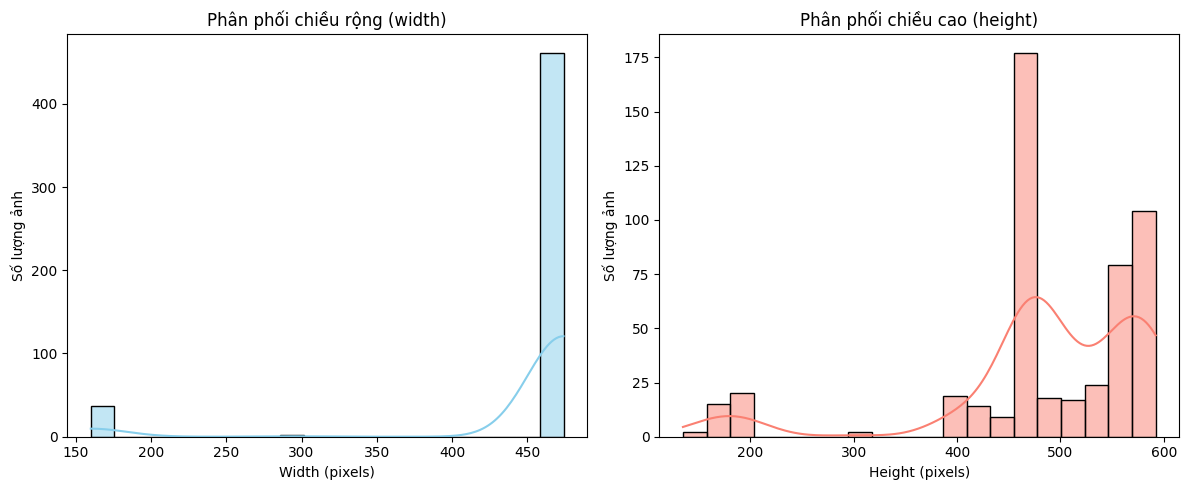

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

image_dir = "image"

widths = []
heights = []

for filename in os.listdir(image_dir):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        image_path = os.path.join(image_dir, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

print(f"Tổng số ảnh: {len(widths)}")
print(f"Chiều rộng - Min: {min(widths)}, Max: {max(widths)}, Mean: {sum(widths)/len(widths):.2f}")
print(f"Chiều cao  - Min: {min(heights)}, Max: {max(heights)}, Mean: {sum(heights)/len(heights):.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True, color='skyblue')
plt.title("Phân phối chiều rộng (width)")
plt.xlabel("Width (pixels)")
plt.ylabel("Số lượng ảnh")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True, color='salmon')
plt.title("Phân phối chiều cao (height)")
plt.xlabel("Height (pixels)")
plt.ylabel("Số lượng ảnh")

plt.tight_layout()
plt.show()


## Build model from scratch

In [5]:
import torch
import torch.nn as nn

class MiniLocalizationNet(nn.Module):
    def __init__(self):
        super(MiniLocalizationNet, self).__init__()

        self.conv = nn.Sequential(
            # Input: 450x450x3
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),   # -> 450x450x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # -> 225x225x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # -> 225x225x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # -> 112x112x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> 112x112x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # -> 56x56x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # -> 56x56x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # -> 28x28x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# -> 28x28x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # -> 14x14x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),# -> 14x14x512
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),                  # -> 13x13x512

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),# -> 13x13x1024
            nn.ReLU(inplace=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # -> 1x1x1024

        self.fc = nn.Sequential(
            nn.Flatten(),                          # -> 1024
            nn.Dropout(0.5),
            nn.Linear(1024, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 4)                     # Output: 4 bounding box values
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x

model = MiniLocalizationNet()
print(model)

MiniLocalizationNet(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2

In [6]:
summary(model, input_size=(1, 3, 450, 450))

Layer (type:depth-idx)                   Output Shape              Param #
MiniLocalizationNet                      [1, 4]                    --
├─Sequential: 1-1                        [1, 1024, 13, 13]         --
│    └─Conv2d: 2-1                       [1, 16, 450, 450]         448
│    └─ReLU: 2-2                         [1, 16, 450, 450]         --
│    └─MaxPool2d: 2-3                    [1, 16, 225, 225]         --
│    └─Conv2d: 2-4                       [1, 32, 225, 225]         4,640
│    └─ReLU: 2-5                         [1, 32, 225, 225]         --
│    └─MaxPool2d: 2-6                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,496
│    └─ReLU: 2-8                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-9                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-10                      [1, 128, 56, 56]          73,856
│    └─ReLU: 2-11                        [1, 128, 56, 56]          --
│  

## Load data

In [7]:
class YOLOLocalizationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

        image = Image.open(img_path).convert("RGB")

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
                bbox_values = lines[0].strip().split()
                bbox = np.array([float(x) for x in bbox_values], dtype=np.float32)
        
        bbox = torch.tensor(bbox, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, bbox

base_dir = "data"
splits = ['train', 'val', 'test']

def get_dataloader(split, transform, batch_size=16, shuffle=False):
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    dataset = YOLOLocalizationDataset(img_dir, label_dir, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


transform = transforms.Compose([
        transforms.Resize((450, 450)),
        transforms.ToTensor()
    ])

train_loader = get_dataloader("train", transform, batch_size=16, shuffle=True)
val_loader = get_dataloader("val", transform, batch_size=16, shuffle=False)
test_loader = get_dataloader("test", transform, batch_size=16, shuffle=False)


In [ ]:
model = MiniLocalizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## IoU Computation function

In [9]:
def compute_iou(pred_bbox, true_bbox):
    pred_x1 = pred_bbox[0] - pred_bbox[2] / 2
    pred_y1 = pred_bbox[1] - pred_bbox[3] / 2
    pred_x2 = pred_bbox[0] + pred_bbox[2] / 2
    pred_y2 = pred_bbox[1] + pred_bbox[3] / 2

    true_x1 = true_bbox[0] - true_bbox[2] / 2
    true_y1 = true_bbox[1] - true_bbox[3] / 2
    true_x2 = true_bbox[0] + true_bbox[2] / 2
    true_y2 = true_bbox[1] + true_bbox[3] / 2

    inter_x1 = max(pred_x1, true_x1)
    inter_y1 = max(pred_y1, true_y1)
    inter_x2 = min(pred_x2, true_x2)
    inter_y2 = min(pred_y2, true_y2)

    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    true_area = (true_x2 - true_x1) * (true_y2 - true_y1)

    union_area = pred_area + true_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0.0
    return iou


## Trai model

Epoch 1/50, Train Loss: 0.0723, Val Loss: 0.0086
Epoch 1/50, Mean IoU: 0.5697
Epoch 2/50, Train Loss: 0.0132, Val Loss: 0.0084
Epoch 2/50, Mean IoU: 0.5543
Epoch 3/50, Train Loss: 0.0122, Val Loss: 0.0096
Epoch 3/50, Mean IoU: 0.5109
Epoch 4/50, Train Loss: 0.0120, Val Loss: 0.0095
Epoch 4/50, Mean IoU: 0.5221
Epoch 5/50, Train Loss: 0.0124, Val Loss: 0.0081
Epoch 5/50, Mean IoU: 0.5655
Epoch 6/50, Train Loss: 0.0115, Val Loss: 0.0095
Epoch 6/50, Mean IoU: 0.5484
Epoch 7/50, Train Loss: 0.0118, Val Loss: 0.0070
Epoch 7/50, Mean IoU: 0.6027
Epoch 8/50, Train Loss: 0.0114, Val Loss: 0.0135
Epoch 8/50, Mean IoU: 0.4389
Epoch 9/50, Train Loss: 0.0112, Val Loss: 0.0087
Epoch 9/50, Mean IoU: 0.5236
Epoch 10/50, Train Loss: 0.0113, Val Loss: 0.0094
Epoch 10/50, Mean IoU: 0.5056
Epoch 11/50, Train Loss: 0.0116, Val Loss: 0.0062
Epoch 11/50, Mean IoU: 0.6129
Epoch 12/50, Train Loss: 0.0121, Val Loss: 0.0087
Epoch 12/50, Mean IoU: 0.5560
Epoch 13/50, Train Loss: 0.0118, Val Loss: 0.0064
Epoch 13

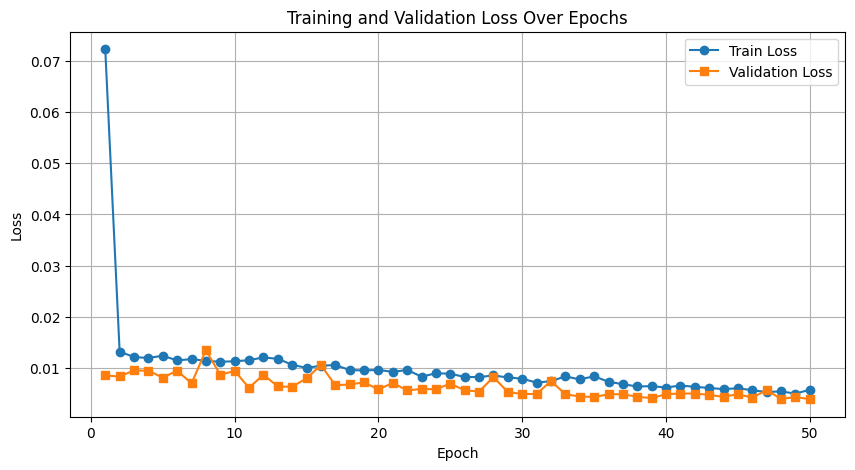

In [10]:
num_epochs = 50
train_losses = []
val_losses = []
all_preds, all_targets = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

   
    model.eval()
    val_loss = 0.0
    ious = []

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs, targets  = imgs.to(device), targets.to(device)
            preds = model(imgs)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            batch_ious = [compute_iou(pred.cpu().numpy(), true.cpu().numpy()) for pred, true in zip(preds, targets)]
            ious.extend(batch_ious)

            loss = criterion(preds, targets)
            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        mean_iou = np.mean(ious)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Mean IoU: {mean_iou:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Evaluation on test set using MSE Loss and IoU

In [11]:
model.eval()
all_preds, all_targets = [], []
ious = []

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)
        preds = model(imgs)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        batch_ious = [compute_iou(pred.cpu().numpy(), true.cpu().numpy()) for pred, true in zip(preds, targets)]
        ious.extend(batch_ious)

mse = mean_squared_error(all_targets, all_preds)
mean_iou = np.mean(ious)
print(f"MSE: {mse:.4f}, Mean IoU: {mean_iou:.4f}")

MSE: 0.0043, Mean IoU: 0.6794


In [12]:
torch.save(model.state_dict(), "model.pth")

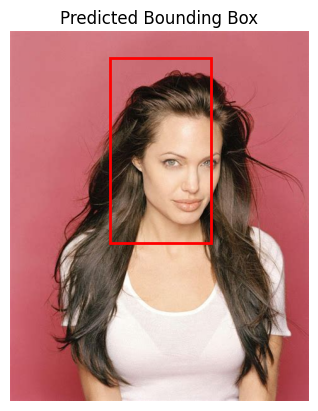

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def predict_and_draw(img_path, model, device, img_size=(450, 450)):
    image = Image.open(img_path).convert("RGB")
    orig_width, orig_height = image.size

    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0].cpu().numpy()

    x_center, y_center, w, h = pred
    x_center *= orig_width
    y_center *= orig_height
    w *= orig_width
    h *= orig_height

    x = x_center - w / 2
    y = y_center - h / 2

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.title("Predicted Bounding Box")
    plt.axis('off')
    plt.show()

img_path = "data/test/images/025_41cee764.jpg" 
predict_and_draw(img_path, model, device)